<a href="https://colab.research.google.com/github/mb8655/Python/blob/main/Multidimensional_Data_Analysis_Lift_and_Logodds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multidimensional Data Analysis

In [1]:
!sudo pip3 install -U sqlalchemy PyMySQL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.6 MB/s eta 0:00:00


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine

#improve graphs visuals
matplotlib.style.use(["seaborn-v0_8-talk", "seaborn-v0_8-ticks", "seaborn-v0_8-whitegrid"])
plt.rcParams['figure.figsize'] = (15, 10)

In [4]:
#create connection to sql database

conn_string_fb = 'mysql+pymysql://{user}:{password}@{host}:{port}/{db}'.format(
    user='student',
    password='dwdstudent2025',
    host='db.ipeirotis.org',
    port=3306,
    db='facebook')
engine_fb = create_engine(conn_string_fb)

##Lift and Log-odds: Facebook, Favorite Books, and Political views
Now let's do an analysis that examines book preferences and how they correlated with political leanings.

We will start by fetching the favorite books for students that declared themselves as Liberal or Conservative.

In [5]:
books = '''
    SELECT B.Book, P.PoliticalViews, COUNT(*) AS cnt
    FROM Profiles P
    JOIN FavoriteBooks B
    ON B.ProfileID = P.ProfileID
    WHERE P.PoliticalViews IS NOT NULL
    AND B.Book IS NOT NULL
    AND P.PoliticalViews IN ('Liberal', 'Conservative')
    AND B.BOOK IN (
        SELECT Book
        FROM FavoriteBooks B
        JOIN Profiles P
        ON P.ProfileID = B.ProfileID
        WHERE P.PoliticalViews IN ('Liberal', 'Conservative')
        GROUP BY Book HAVING COUNT(DISTINCT P.ProfileID) > 10
    )
    GROUP BY B.Book, P.PoliticalViews;
'''
df_books = pd.read_sql(books, engine_fb)
df_books.head(10)

,Book,PoliticalViews,cnt
0,Memoirs Of A Geisha,Conservative,17
1,Middlesex,Conservative,2
2,Cat S Cradle,Conservative,6
3,Diary,Conservative,2
4,The Bible,Conservative,21
5,Liar S Poker,Conservative,18
6,The Prince,Conservative,14
7,Lotr,Conservative,13
8,The Count Of Monte Cristo,Conservative,8
9,American Gods,Liberal,16


In [6]:
# view the length
len(df_books)

715

In [7]:
#Create pivot table

dfp = df_books.pivot_table(
    index='Book',
    columns='PoliticalViews',
    values='cnt')
dfp.head(10)

PoliticalViews,Conservative,Liberal
Book,,
100 Years Of Solitude,3.0,55.0
1984,32.0,286.0
A Clockwork Orange,8.0,86.0
A Confederacy Of Dunces,2.0,37.0
A Doll S House,NaN,12.0
A Farewell To Arms,8.0,36.0
A Fine Balance,NaN,23.0
A Heartbreaking Work Of Staggering Genius,8.0,70.0
A Million Little Pieces,7.0,39.0


#update columns to
Notice the NaN values for the entries where we had no users falling into that group. Since we will want to do calculations for these books as well, we will use the fillna command to fill these entries with a default value (in our case, 0)

In [9]:
#fill the NaN entries with zero
dfp = df_books.pivot_table(
    index='Book',
    columns='PoliticalViews',
    values='cnt').fillna(0)

dfp.head(10)



PoliticalViews,Conservative,Liberal
Book,,
100 Years Of Solitude,3.0,55.0
1984,32.0,286.0
A Clockwork Orange,8.0,86.0
A Confederacy Of Dunces,2.0,37.0
A Doll S House,0.0,12.0
A Farewell To Arms,8.0,36.0
A Fine Balance,0.0,23.0
A Heartbreaking Work Of Staggering Genius,8.0,70.0
A Million Little Pieces,7.0,39.0


##Normalization of data
We now want to normalize the entries before proceeding further. Let's take a look at the breakdown of political views in the database.

In [10]:
polviews = '''
    SELECT PoliticalVIEWS, COUNT(*) AS cnt
    FROM facebook.Profiles
    GROUP BY PoliticalViews;
'''
df_polviews = pd.read_sql(polviews, engine_fb)
df_polviews

,PoliticalVIEWS,cnt
0,None,11091
1,Libertarian,325
2,Conservative,936
3,Liberal,6461
4,Apathetic,805
5,Moderate,2898
6,Very Liberal,2277
7,Very Conservative,167
8,Other,824


In [13]:
df_polviews.set_index('PoliticalVIEWS', inplace=True)
df_polviews

,cnt
PoliticalVIEWS,
None,11091
Libertarian,325
Conservative,936
Liberal,6461
Apathetic,805
Moderate,2898
Very Liberal,2277
Very Conservative,167
Other,824


In [16]:
#select the liberal count
liberals = df_polviews.at['Liberal', 'cnt']
liberals


np.int64(6461)

In [17]:
#select the conservative count
conservatives = df_polviews.at['Conservative', 'cnt']
conservatives

np.int64(936)

##Since we have many more conservatives than liberals, let's create a new column that calculates the percentage of liberal and conservative students that liked each book. We add the +1 in the numerator to avoid division by zero later on. As practice, try to fetch the values 936 and 6461 directly from the database, and automate the calculation.

In [20]:
dfp['Liberal_perc'] = 100*(dfp['Liberal'] + 1) / liberals
dfp['Conservative_perc'] = 100*(dfp['Conservative'] + 1) / conservatives
dfp.head(10)


PoliticalViews,Conservative,Liberal,Liberal_perc,Conservative_perc
Book,,,,
100 Years Of Solitude,3.0,55.0,0.866739,0.427350
1984,32.0,286.0,4.442037,3.525641
A Clockwork Orange,8.0,86.0,1.346541,0.961538
A Confederacy Of Dunces,2.0,37.0,0.588144,0.320513
A Doll S House,0.0,12.0,0.201207,0.106838
A Farewell To Arms,8.0,36.0,0.572667,0.961538
A Fine Balance,0.0,23.0,0.371460,0.106838
A Heartbreaking Work Of Staggering Genius,8.0,70.0,1.098901,0.961538
A Million Little Pieces,7.0,39.0,0.619099,0.854701


In [21]:
#Review "Harry Potter" book
dfp.loc['Harry Potter']

,Harry Potter
PoliticalViews,
Conservative,66.000000
Liberal,555.000000
Liberal_perc,8.605479
Conservative_perc,7.158120


#Lift
Now that we have the normalized values, we can compute the lift for each book. The lift is the ratio between the percentage of liberals and the percentage of convervatives. A book with lift==1 will be equally read by both conservatives and liberals. Books that have lifts significantly higher or lower than 1, reveal preferences to be read by one side of the political spectrum.

In [22]:
dfp['lift_lib'] = dfp['Liberal_perc'] / dfp['Conservative_perc']
dfp['lift_con'] = dfp['Conservative_perc'] / dfp['Liberal_perc']
dfp.head(10)

PoliticalViews,Conservative,Liberal,Liberal_perc,Conservative_perc,lift_lib,lift_con
Book,,,,,,
100 Years Of Solitude,3.0,55.0,0.866739,0.427350,2.028169,0.493056
1984,32.0,286.0,4.442037,3.525641,1.259923,0.793699
A Clockwork Orange,8.0,86.0,1.346541,0.961538,1.400402,0.714080
A Confederacy Of Dunces,2.0,37.0,0.588144,0.320513,1.835010,0.544956
A Doll S House,0.0,12.0,0.201207,0.106838,1.883300,0.530983
A Farewell To Arms,8.0,36.0,0.572667,0.961538,0.595573,1.679054
A Fine Balance,0.0,23.0,0.371460,0.106838,3.476861,0.287616
A Heartbreaking Work Of Staggering Genius,8.0,70.0,1.098901,0.961538,1.142857,0.875000
A Million Little Pieces,7.0,39.0,0.619099,0.854701,0.724346,1.380556


In [25]:
#reformat to have lift closer to the books
dfp = dfp[ ['lift_lib', 'lift_con', 'Liberal_perc', 'Conservative_perc', 'Liberal', 'Conservative'] ]
dfp.head(10)


PoliticalViews,lift_lib,lift_con,Liberal_perc,Conservative_perc,Liberal,Conservative
Book,,,,,,
100 Years Of Solitude,2.028169,0.493056,0.866739,0.427350,55.0,3.0
1984,1.259923,0.793699,4.442037,3.525641,286.0,32.0
A Clockwork Orange,1.400402,0.714080,1.346541,0.961538,86.0,8.0
A Confederacy Of Dunces,1.835010,0.544956,0.588144,0.320513,37.0,2.0
A Doll S House,1.883300,0.530983,0.201207,0.106838,12.0,0.0
A Farewell To Arms,0.595573,1.679054,0.572667,0.961538,36.0,8.0
A Fine Balance,3.476861,0.287616,0.371460,0.106838,23.0,0.0
A Heartbreaking Work Of Staggering Genius,1.142857,0.875000,1.098901,0.961538,70.0,8.0
A Million Little Pieces,0.724346,1.380556,0.619099,0.854701,39.0,7.0


#Log-odds
One common tranformation is to take the log of the lift. We call this metric log odds. In that case, the lift==1 corresponds to a log_odds of 0. Negative values indicate negative association, and positive values indicate positive association. A nice property of log-odds is that they are additive, which means that summing up log-odds makes (mathematical) sense, under some reasonably general conditions. (The details are beyond the scope of this course, but you can learn more in the data mining class.)

In [26]:
import numpy as np
dfp['log_odds_lib'] = np.log(dfp['lift_lib'])
dfp['log_odds_con'] = np.log(dfp['lift_con'])
dfp.head(10)

PoliticalViews,lift_lib,lift_con,Liberal_perc,Conservative_perc,Liberal,Conservative,log_odds_lib,log_odds_con
Book,,,,,,,,
100 Years Of Solitude,2.028169,0.493056,0.866739,0.427350,55.0,3.0,0.707133,-0.707133
1984,1.259923,0.793699,4.442037,3.525641,286.0,32.0,0.231051,-0.231051
A Clockwork Orange,1.400402,0.714080,1.346541,0.961538,86.0,8.0,0.336760,-0.336760
A Confederacy Of Dunces,1.835010,0.544956,0.588144,0.320513,37.0,2.0,0.607050,-0.607050
A Doll S House,1.883300,0.530983,0.201207,0.106838,12.0,0.0,0.633025,-0.633025
A Farewell To Arms,0.595573,1.679054,0.572667,0.961538,36.0,8.0,-0.518231,0.518231
A Fine Balance,3.476861,0.287616,0.371460,0.106838,23.0,0.0,1.246130,-1.246130
A Heartbreaking Work Of Staggering Genius,1.142857,0.875000,1.098901,0.961538,70.0,8.0,0.133531,-0.133531
A Million Little Pieces,0.724346,1.380556,0.619099,0.854701,39.0,7.0,-0.322486,0.322486


In [27]:
# reformat columns

dfp = dfp[ ['log_odds_lib', 'log_odds_con', 'lift_lib', 'lift_con', 'Liberal_perc', 'Conservative_perc', 'Liberal', 'Conservative'] ]
dfp.head(10)

PoliticalViews,log_odds_lib,log_odds_con,lift_lib,lift_con,Liberal_perc,Conservative_perc,Liberal,Conservative
Book,,,,,,,,
100 Years Of Solitude,0.707133,-0.707133,2.028169,0.493056,0.866739,0.427350,55.0,3.0
1984,0.231051,-0.231051,1.259923,0.793699,4.442037,3.525641,286.0,32.0
A Clockwork Orange,0.336760,-0.336760,1.400402,0.714080,1.346541,0.961538,86.0,8.0
A Confederacy Of Dunces,0.607050,-0.607050,1.835010,0.544956,0.588144,0.320513,37.0,2.0
A Doll S House,0.633025,-0.633025,1.883300,0.530983,0.201207,0.106838,12.0,0.0
A Farewell To Arms,-0.518231,0.518231,0.595573,1.679054,0.572667,0.961538,36.0,8.0
A Fine Balance,1.246130,-1.246130,3.476861,0.287616,0.371460,0.106838,23.0,0.0
A Heartbreaking Work Of Staggering Genius,0.133531,-0.133531,1.142857,0.875000,1.098901,0.961538,70.0,8.0
A Million Little Pieces,-0.322486,0.322486,0.724346,1.380556,0.619099,0.854701,39.0,7.0


In [28]:
# view only certain columns

show_cols = ['log_odds_lib', 'log_odds_con', 'lift_lib', 'lift_con', 'Liberal', 'Conservative']
dfp[show_cols].head(10)

PoliticalViews,log_odds_lib,log_odds_con,lift_lib,lift_con,Liberal,Conservative
Book,,,,,,
100 Years Of Solitude,0.707133,-0.707133,2.028169,0.493056,55.0,3.0
1984,0.231051,-0.231051,1.259923,0.793699,286.0,32.0
A Clockwork Orange,0.336760,-0.336760,1.400402,0.714080,86.0,8.0
A Confederacy Of Dunces,0.607050,-0.607050,1.835010,0.544956,37.0,2.0
A Doll S House,0.633025,-0.633025,1.883300,0.530983,12.0,0.0
A Farewell To Arms,-0.518231,0.518231,0.595573,1.679054,36.0,8.0
A Fine Balance,1.246130,-1.246130,3.476861,0.287616,23.0,0.0
A Heartbreaking Work Of Staggering Genius,0.133531,-0.133531,1.142857,0.875000,70.0,8.0
A Million Little Pieces,-0.322486,0.322486,0.724346,1.380556,39.0,7.0


In [29]:
# liberal books

lib_books = (
    dfp[show_cols]
    .sort_values('lift_lib', ascending=False)
    .head(11)
)
lib_books


PoliticalViews,log_odds_lib,log_odds_con,lift_lib,lift_con,Liberal,Conservative
Book,,,,,,
The Little Prince,2.462525,-2.462525,11.734406,0.085219,80.0,0.0
Fear And Loathing In Las Vegas,2.128519,-2.128519,8.402414,0.119013,57.0,0.0
The God Of Small Things,1.805746,-1.805746,6.084507,0.164352,41.0,0.0
David Sedaris,1.705662,-1.705662,5.505030,0.181652,37.0,0.0
Perks Of Being A Wallflower,1.651595,-1.651595,5.215292,0.191744,35.0,0.0
The Virgin Suicides,1.623424,-1.623424,5.070423,0.197222,34.0,0.0
Dante S Inferno,1.623424,-1.623424,5.070423,0.197222,34.0,0.0
The Kite Runner,1.518064,-1.518064,4.563380,0.219136,62.0,1.0
The Unbearable Lightness Of Being,1.512759,-1.512759,4.539235,0.220301,93.0,2.0


In [30]:
#conservative books

con_books = (
    dfp[show_cols]
    .sort_values('lift_con', ascending=False)
    .head(11)
)
con_books

PoliticalViews,log_odds_lib,log_odds_con,lift_lib,lift_con,Liberal,Conservative
Book,,,,,,
Liar S Poker,-3.084603,3.084603,0.045748,21.858796,5.0,18.0
Bible,-2.250378,2.250378,0.105359,9.491319,7.0,10.0
Mere Christianity,-2.086075,2.086075,0.124174,8.053241,5.0,6.0
Monkey Business,-2.049707,2.049707,0.128773,7.765625,7.0,8.0
The Bible,-1.764870,1.764870,0.171209,5.840812,25.0,21.0
Moneyball,-1.461920,1.461920,0.231791,4.314236,15.0,9.0
The Prince,-1.381878,1.381878,0.251107,3.982372,25.0,14.0
War And Peace,-1.344137,1.344137,0.260765,3.834877,8.0,4.0
Fountainhead,-1.344137,1.344137,0.260765,3.834877,8.0,4.0


Text(0.5, 0, 'Lift for Libarals')

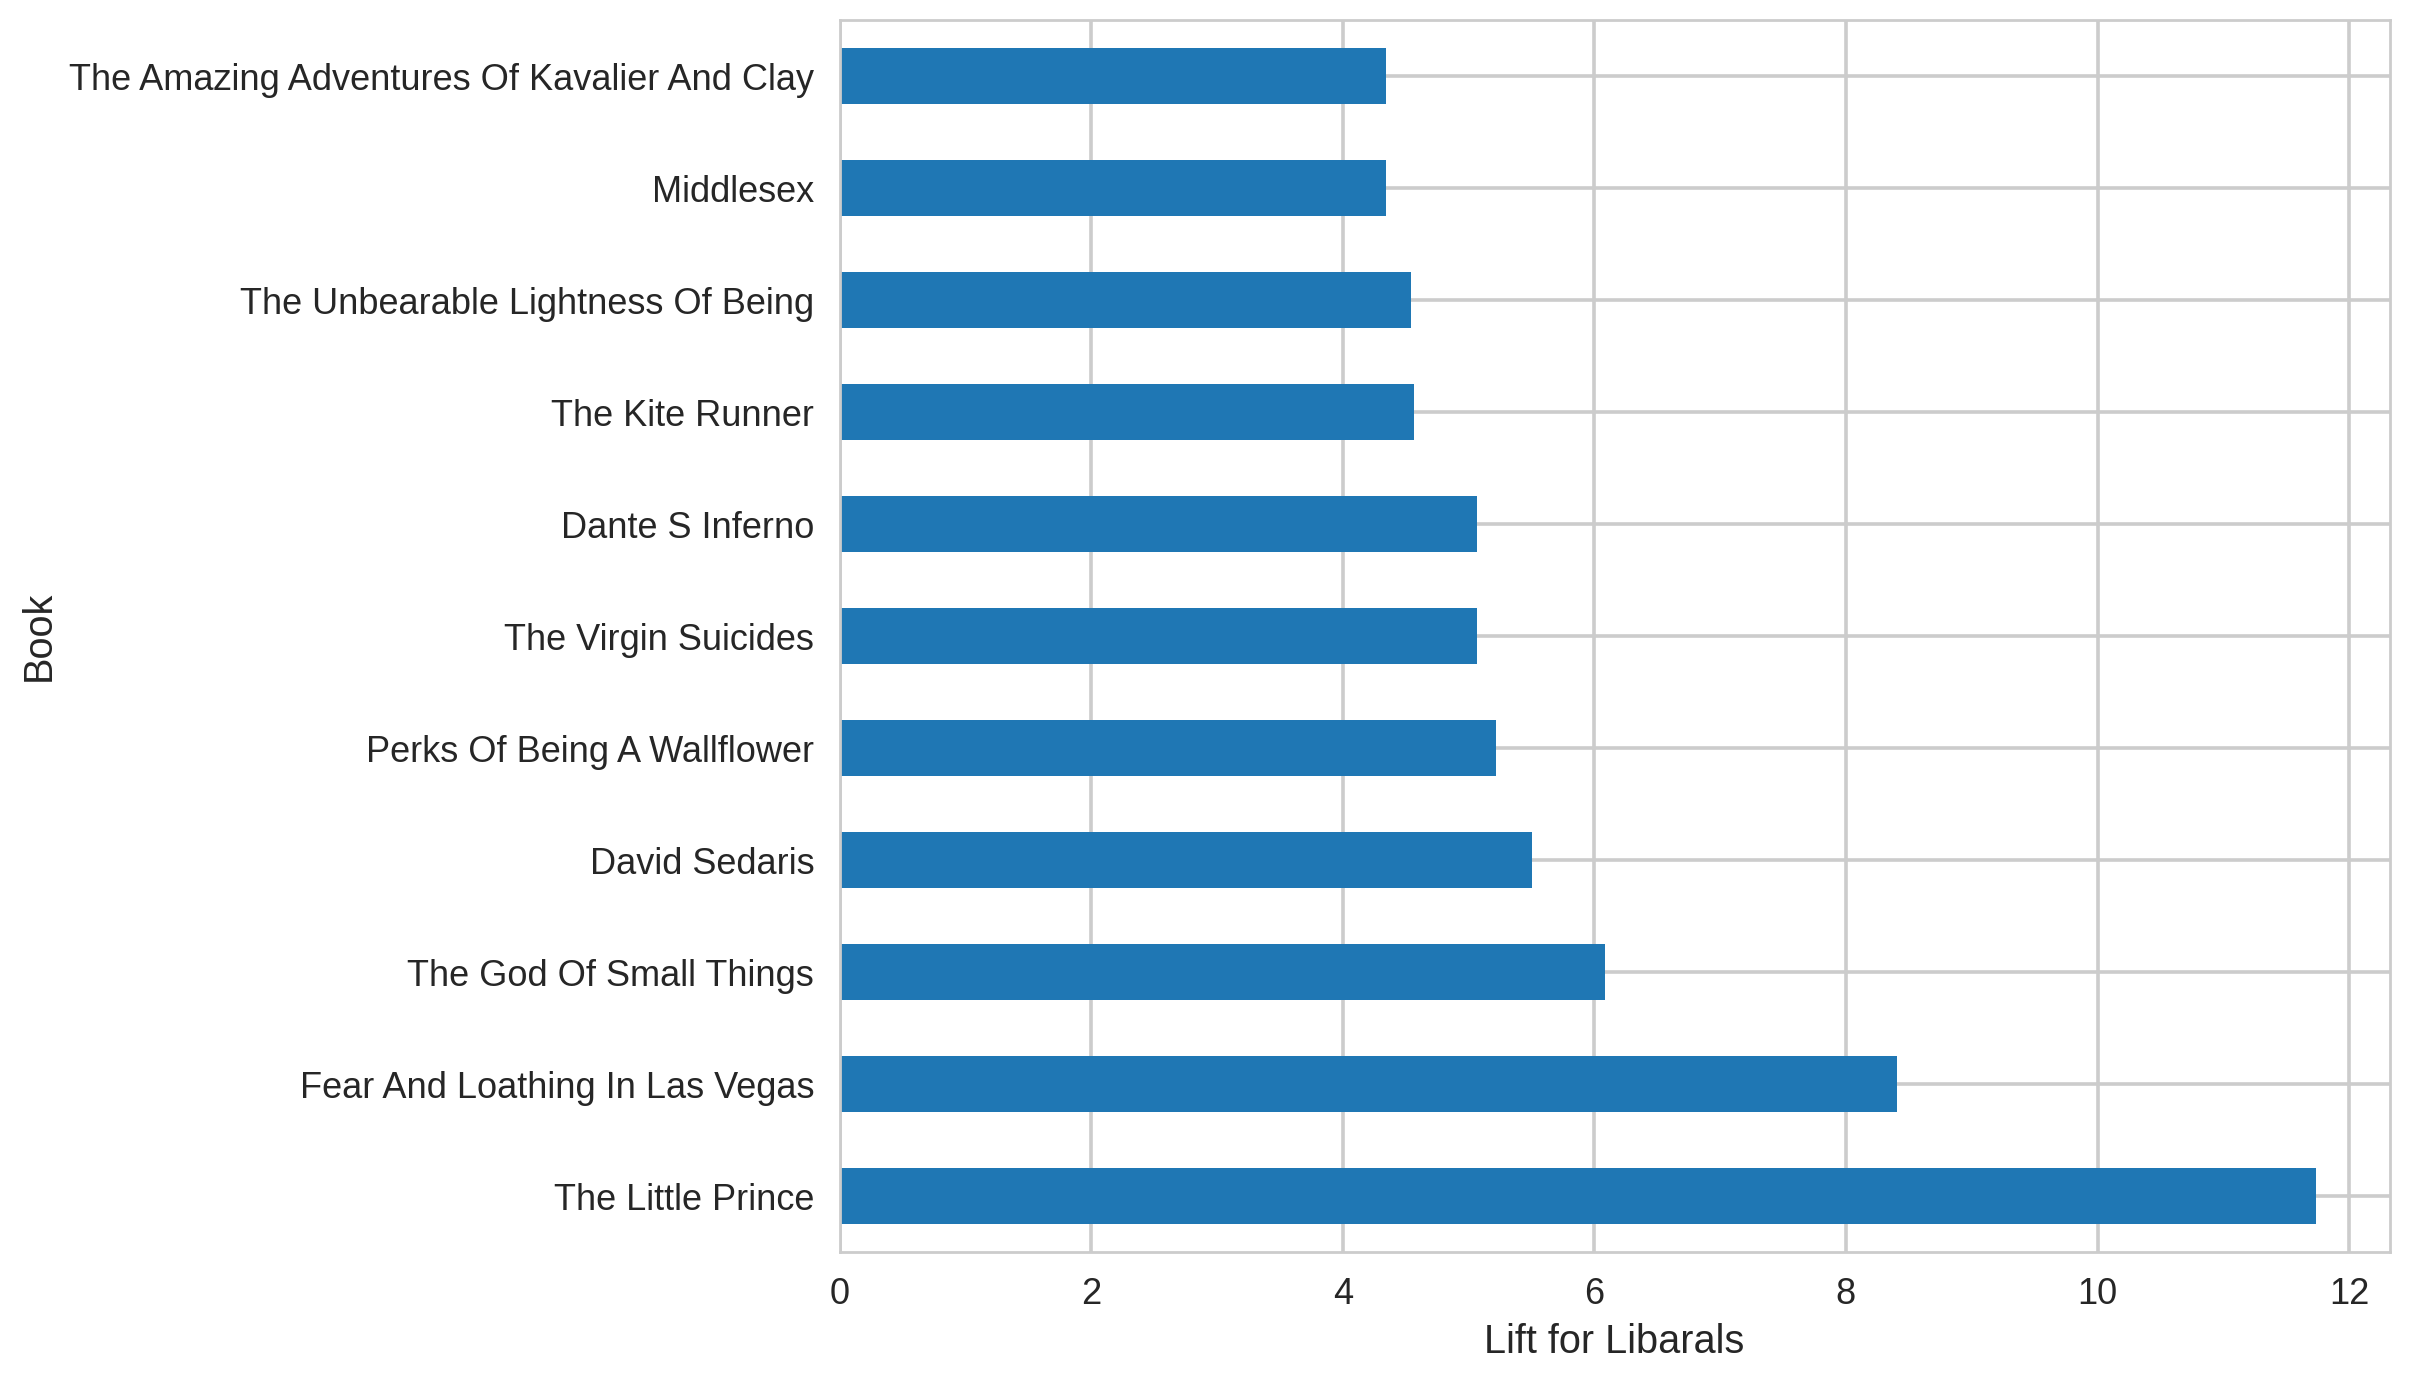

In [31]:
plot = lib_books.lift_lib.plot(kind='barh', figsize=(10, 8))
plot.set_xlabel('Lift for Libarals')

Text(0.5, 0, 'Lift fot Conservatives')

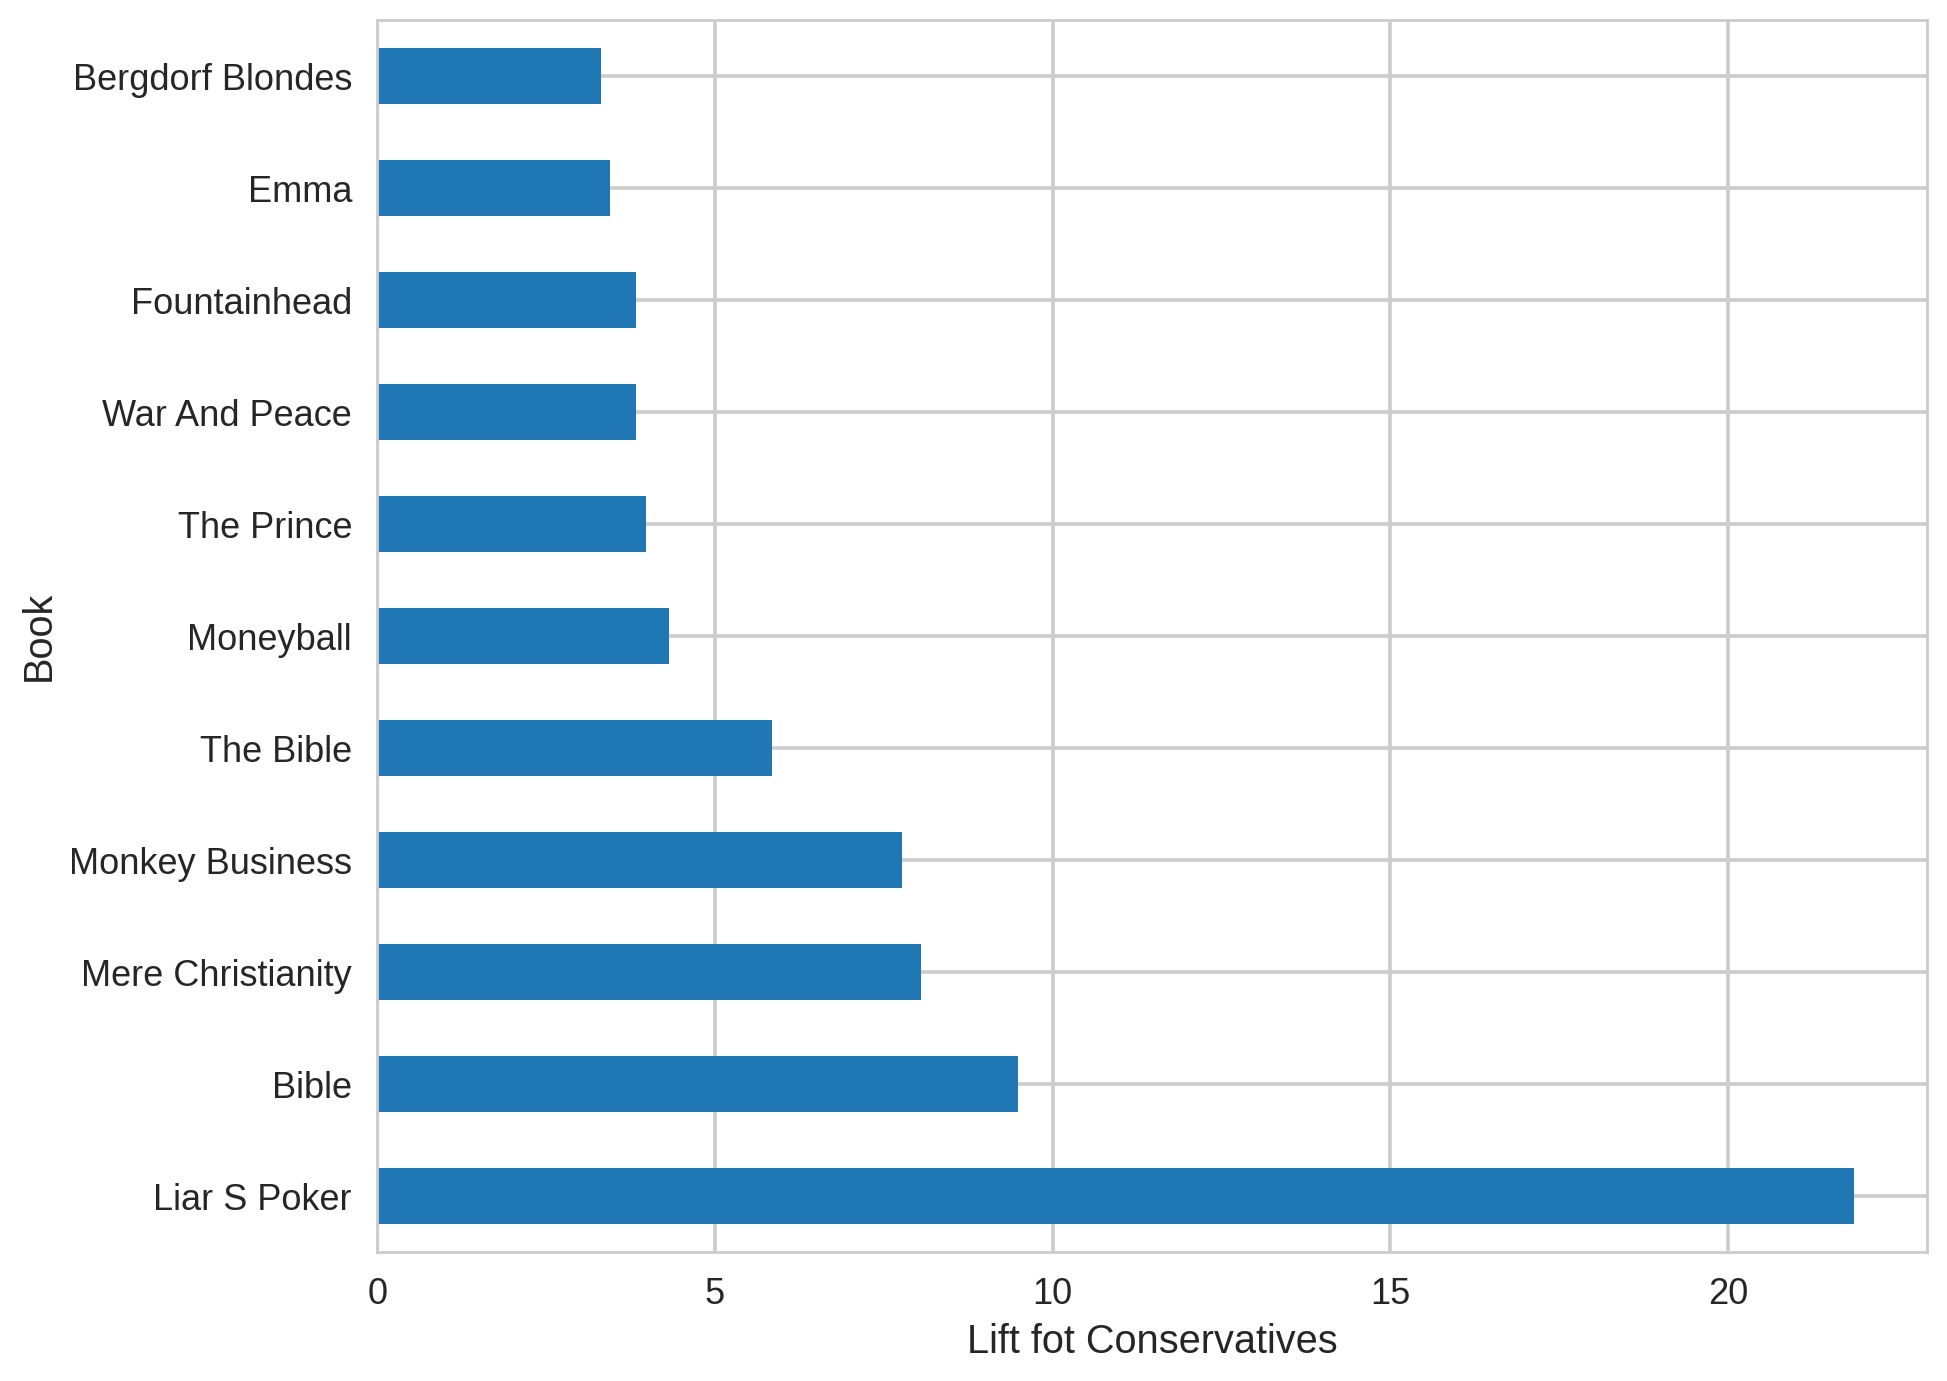

In [32]:
plot = con_books.lift_con.plot(kind='barh', figsize=(10, 8))
plot.set_xlabel('Lift for Conservatives')
